In [ ]:
!cd gdrive/MyDrive/

In [ ]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import collections
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
def read_data(data_path:str,encoding='utf8'):
    data = open(data_path,'r',encoding=encoding).read().replace('\u200b','').split('\n')
    while not data[-1]:
        del data[-1]
    return data
en_datas =[]
zhcn_datas = [] 
data1 = read_data(r'/content/gdrive/MyDrive/data/translation/val.en')
data2 = read_data(r'/content/gdrive/MyDrive/data/translation/news-commentary-v16.en')[:30000]
data3 = read_data(r'/content/gdrive/MyDrive/data/translation/val.zh')
data4 = read_data(r'/content/gdrive/MyDrive/data/translation/news-commentary-v16.zh')[:30000]
en_datas.extend(data1)
en_datas.extend(data2)
zhcn_datas.extend(data3)
zhcn_datas.extend(data4)


print('英文数量:',len(en_datas))
print('中文数量:',len(zhcn_datas))

英文数量: 30900
中文数量: 30900


In [ ]:
# 文字转id
def tokenize(x,char_level=False):
    x_tk = Tokenizer(char_level=char_level)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk
en_tokenized, en_tokenizer =tokenize(en_datas)
zhcn_tokenized, zhcn_tokenizer =tokenize(zhcn_datas,char_level=True)
# 填充长度
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen=length, padding='post')
preprocess_x = pad(en_tokenized)
preprocess_y = pad(zhcn_tokenized)[:,:,None]


In [ ]:
def logits_to_text(logits, tokenizer):
    index_to_words = {_id:word for word,_id in tokenizer.word_index.items()}
    index_to_words[0]='<PAD>'
    return ''.join([index_to_words[index] for index in np.argmax(logits, 1)])
    

In [ ]:
!nvidia-smi

Sat May  1 14:20:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    42W /  70W |   4960MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def translation_model(input_shape, output_sequence_length, english_vocab_size, zhcn_vocab_size):
    input_seq = Input((input_shape[1:]))
    x = Embedding(english_vocab_size,64)(input_seq)
    x = Bidirectional(GRU(64,dropout=0.2,return_sequences=False))(x)
    x = RepeatVector(output_sequence_length)(x)
    x = Bidirectional(GRU(128,dropout=0.2,return_sequences=True))(x)
    x = TimeDistributed(Dense(zhcn_vocab_size))(x)
    x = Activation('softmax')(x)
    model = Model(input_seq,x)
    lr = 0.03
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(lr,decay=0.01), 
                 metrics = ['accuracy'])
    return model
    
    
model = translation_model(preprocess_x.shape,preprocess_y.shape[1],len(en_tokenizer.word_index)+1,len(zhcn_tokenizer.word_index)+1)

mc = ModelCheckpoint(filepath=r'weight\ep{epoch:03d}val_loss{val_loss:.3f}val_acc{val_accuracy:.3f}.h5',save_best_only=True,save_weights_only=True,verbose=1)
es = EarlyStopping(patience=5,min_delta=0.001)
his = model.fit(preprocess_x, preprocess_y, 
                 batch_size=64, epochs=200, 
                 validation_split=0.2,
                 callbacks=[mc,es])

Epoch 1/200
387/387 [==============================] - 135s 338ms/step - loss: 1.1771 - accuracy: 0.8705 - val_loss: 0.8494 - val_accuracy: 0.8883

Epoch 00001: val_loss improved from inf to 0.84936, saving model to weight\ep001val_loss0.849val_acc0.888.h5
Epoch 2/200
387/387 [==============================] - 130s 335ms/step - loss: 0.8582 - accuracy: 0.8853 - val_loss: 0.8389 - val_accuracy: 0.8884

Epoch 00002: val_loss improved from 0.84936 to 0.83888, saving model to weight\ep002val_loss0.839val_acc0.888.h5
Epoch 3/200
387/387 [==============================] - 130s 336ms/step - loss: 0.8367 - accuracy: 0.8856 - val_loss: 0.8625 - val_accuracy: 0.8877

Epoch 00003: val_loss did not improve from 0.83888
Epoch 4/200
387/387 [==============================] - 130s 335ms/step - loss: 0.8197 - accuracy: 0.8855 - val_loss: 0.8591 - val_accuracy: 0.8877

Epoch 00004: val_loss did not improve from 0.83888
Epoch 5/200
387/387 [==============================] - 130s 335ms/step - loss: 0.804

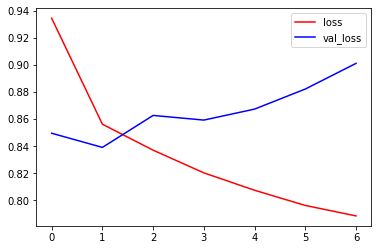

In [ ]:
loss=his.history['loss']
val_loss=his.history['val_loss']
plt.plot(range(len(loss)),loss,color='red')
plt.plot(range(len(val_loss)),val_loss,color='blue')
plt.legend(labels=['loss','val_loss',])
import pandas as pd
pd.DataFrame(his.history).to_csv('/content/gdrive/MyDrive/result/loss.csv', index = False)
model.save('/content/gdrive/MyDrive/result/his.h5')

In [ ]:
ens = en_datas[:15]
zhcns = zhcn_datas[:15]
predicts = model.predict(preprocess_x[:15])
for en, zhcn,predict in zip(ens,zhcns,predicts):
    print('英文输入:',en)
#     print(zhcn)
    print('翻译结果:',logits_to_text(predict,zhcn_tokenizer))
    print()
    

英文输入: Interest income is recognised using the effective interest method for financial assets measured subsequently at amortised cost.
翻译结果: 但国，，，，，，，，，的的的的的的的<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><P